### Business Problem
An e-commerce company wants to segment its customers and determine marketing strategies according to these segments.

For this purpose, we will define the behavior of customers and we will form groups according to clustering.

### Column Descriptors
InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. <br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric. <br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. <br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
Country: Country name. Nominal. The name of the country where a customer resides. <br>

### 1. Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset

df = pd.read_csv('C:/Users/vumac/Desktop/Springboard_Capstone3/Dataset/online_retail_cleaned.csv', encoding= 'unicode_escape', index_col=0)

### 2. Pre-processing

In [3]:
# Create a 'Revenue' column

df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df["Revenue"] = df["Quantity"]*df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [4]:
# Check the lastest invoice date

df.InvoiceDate.max()

Timestamp('2011-12-09 00:00:00')

In [5]:
# Do not know when the dataset was extracted.
# Set current day to 3 days from the latest invoice, to ensure no frequency value is 0

today_date = df['InvoiceDate'].max() + dt.timedelta(days=3)
today_date

Timestamp('2011-12-12 00:00:00')

In [6]:
# Calculate the RFM metrics:
# Recency: The number of days between today_date and the last purchase date of this customer
# Recency (for BG-NBD Model): The age of the customer at the time of their last purchase.
# Monetary: The total or average sales of the customer.
# Frequency: Number of purchases/transactions.
# Age: The age of the customer since the date of a customer's first purchase to the current date.

rfm = df.groupby("Customer ID").agg({"InvoiceDate": [lambda x: (today_date - x.max()).days,
                                                     lambda x: (x.max() - x.min()).days,
                                                     lambda x: (today_date - x.min()).days],
                               "Invoice": lambda x: x.nunique(),
                               "Revenue": lambda x: x.sum()})

rfm.columns = ["recency", "recency_bg", "age", "frequency", "monetary"]

rfm = rfm[["recency", "recency_bg", "frequency", "monetary", "age"]]

rfm.head()

,recency,recency_bg,frequency,monetary,age
Customer ID,,,,,
12347.0,5,365,7,4060.40,370
12348.0,78,283,4,1186.68,361
12349.0,21,0,1,1353.80,21
12350.0,313,0,1,294.40,313
12352.0,39,260,7,1385.74,299


In [7]:
# Give a score from 1 to 5 to each value for ranking

rfm["R"] = pd.qcut(rfm['recency'], q=5, labels=range(5, 0, -1))

rfm["F"] = pd.qcut(rfm['frequency'].rank(method="first"), q=5, labels=range(1, 6))

rfm["M"] = (pd.qcut(rfm['monetary'], q=5, labels=range(1, 6)))

rfm.head()

,recency,recency_bg,frequency,monetary,age,R,F,M
Customer ID,,,,,,,,
12347.0,5,365,7,4060.40,370,5,5,5
12348.0,78,283,4,1186.68,361,2,4,4
12349.0,21,0,1,1353.80,21,4,1,4
12350.0,313,0,1,294.40,313,1,1,2
12352.0,39,260,7,1385.74,299,3,5,4


In [8]:
# Concatenate RFM score values to RFM_Segment

def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,recency,recency_bg,frequency,monetary,age,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,,,
12347.0,5,365,7,4060.40,370,5,5,5,555,15
12348.0,78,283,4,1186.68,361,2,4,4,244,10
12349.0,21,0,1,1353.80,21,4,1,4,414,9
12350.0,313,0,1,294.40,313,1,1,2,112,4
12352.0,39,260,7,1385.74,299,3,5,4,354,12


In [9]:
# Prepare the data for KMean Clustering
# Scale the recency, frequency and monetary values using MinMaxScaler

scaler = MinMaxScaler()

rfm_cluster = pd.DataFrame(scaler.fit_transform(rfm[["recency", "frequency", "monetary", "age"]]),
                            index=rfm.index, columns=["recency", "frequency", "monetary", "age"])

rfm_cluster.reset_index(inplace=True)

rfm_cluster.head()

,Customer ID,recency,frequency,monetary,age
0,12347.0,0.005362,0.029412,0.025525,0.983914
1,12348.0,0.201072,0.014706,0.007447,0.959786
2,12349.0,0.048257,0.000000,0.008498,0.048257
3,12350.0,0.831099,0.000000,0.001834,0.831099
4,12352.0,0.096515,0.029412,0.008699,0.793566


In [10]:
# Drop Customer ID column

x_cols = rfm_cluster.iloc[:, 1:]
X = x_cols.to_numpy()

### 2. Customer segmentation

#### 2.1 KMeans

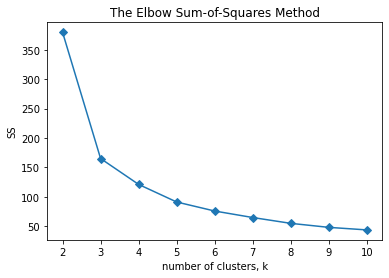

In [11]:
# Choosing K: The Elbow Sum-of-Squares Method

k_number = range(2, 11)
SS = []
kmeans = {}
for i in k_number:
    model = KMeans(n_clusters=i, random_state=48)
    result = model.fit_predict(X)
    center = model.cluster_centers_
    SS.append(np.sum((X - center[result]) ** 2))
    kmeans[i] = result
    
plt.plot(k_number, SS, marker='D')
plt.xticks(k_number)
plt.xlabel('number of clusters, k')
plt.ylabel('SS')
plt.title('The Elbow Sum-of-Squares Method')
plt.grid(False);

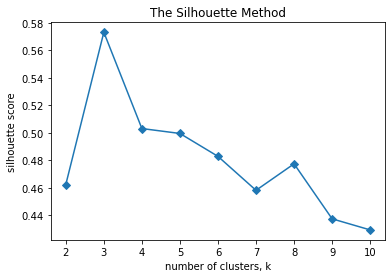

In [12]:
# Choosing K: The Silhouette Method

avg_silhouette_scores = []

k_number = range(2, 11)

for n_clusters in k_number:
    clusterer = KMeans(n_clusters=n_clusters, random_state=48)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

# Draw the silhouette score of each K
    
plt.plot(k_number, avg_silhouette_scores, marker='D')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(k_number)
plt.title('The Silhouette Method')
plt.grid(False);

It is clear that the best number of cluster is 3. Both the Elbow Sum-of-Squares Method and the Silhouette Method showed the same results.

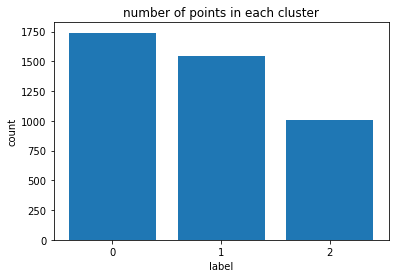

In [13]:
# KMeans model with best K (3)

kmeans = KMeans(n_clusters=3, random_state=48)
cluster_labels = kmeans.fit_predict(X)

rfm['kmean'] = cluster_labels

# Bar chart showing the number of points in each cluster for k-means under the best K (3)

clusters, counts = np.unique(cluster_labels, return_counts=True)

plt.bar(['0', '1', '2'], counts)
plt.ylabel('count')
plt.xlabel('label')
plt.title('number of points in each cluster');

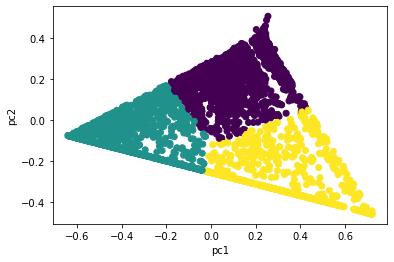

In [14]:
# Visualizing Clusters using PCA

pca = PCA(n_components=2)
pca_comonents = pca.fit_transform(X)
pc1 = pca_comonents[:, 0]
pc2 = pca_comonents[:, 1]

df_pca = pd.DataFrame({'cluster_id':cluster_labels, 'x':pc1, 'y':pc2})

plt.scatter(df_pca.x, df_pca.y, c=df_pca.cluster_id)
plt.grid(False)
plt.xlabel('pc1')
plt.ylabel('pc2');

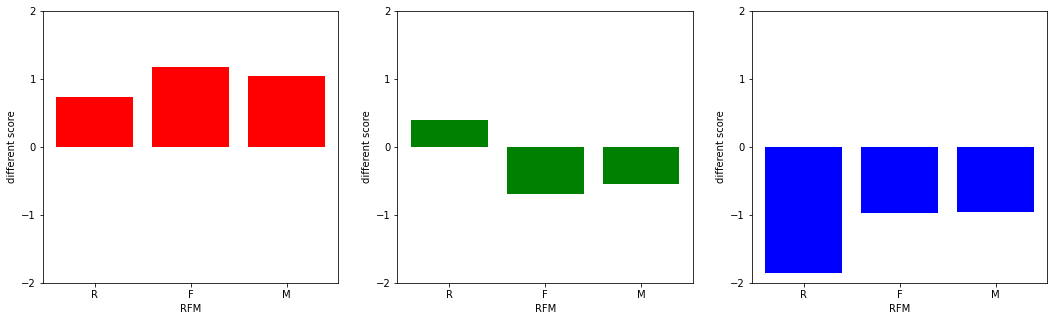

In [15]:
# Visualize difference between each RFM score in each cluster vs globally

# Convert RFM score from string to integer
rfm.iloc[:, 5:8] = rfm.iloc[:, 5:8].astype('int')

# Draw bar graph showing differences
colors = ['red', 'green', 'blue']
avg_scores = rfm.iloc[:, 5:8].mean()
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    avg_scores_cluster = rfm.iloc[:, 5:8][cluster_labels == i].mean()
    diff = avg_scores_cluster - avg_scores
    plt.bar(['R', 'F', 'M'], diff, color=colors[i])
    plt.xlabel('RFM')
    plt.ylabel('different score')
    plt.yticks((-2, -1, 0, 1, 2))

In [16]:
rfm.groupby('kmean')['age'].mean()

kmean
0    313.340805
1     87.069994
2    285.539225
Name: age, dtype: float64

Cluster 1: These were customers that generated the most sales for the companies. All of their RFM metrics were higher than an average customer. They purchased regularly with high invoices' amount. Most of them had purchased recently. They could be recognized as loyal customers.

Cluster 2: These were new customers with recent purchases. It looks like they were trying new products with small purchases. Therefore, their frequency and monetary scores were below average. These were potential customers, if targeted appropriately, they can become loyal customers.

Cluster 3: These were old customers with very few to no purchases. Their recency was low. Their frequency and monetary scores were also below average. It looks like the companies has lost these customers.

#### 2.2 RFM analysis for Customer Segmentation

The RFM Model is also a very useful tool to conduct customer segmentation

<img src="image.png">

In [17]:
# Label each customer based on the RFM model

rfm["RF_Score"] = (rfm['R'].astype(str) +
                    rfm['F'].astype(str))

map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['segment'] = rfm['RF_Score'].replace(map, regex=True)

rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        55.342029   345   1.142029   345   458.519275   345
at_Risk              156.113793   580   2.850000   580   875.641331   580
cant_loose           139.426230    61   8.311475    61  2364.218033    61
champions              8.665635   646  11.936533   646  5093.197276   646
hibernating          219.378175  1063   1.094073  1063   371.663096  1063
loyal_customers       36.228247   793   6.339218   793  2440.246773   793
need_attention        54.248677   189   2.306878   189   802.254444   189
new_customers         10.266667    45   1.000000    45   276.168222    45
potential_loyalists   19.399168   481   1.989605   481   627.335281   481
promising             25.954023    87   1.000000    87   272.518736    87

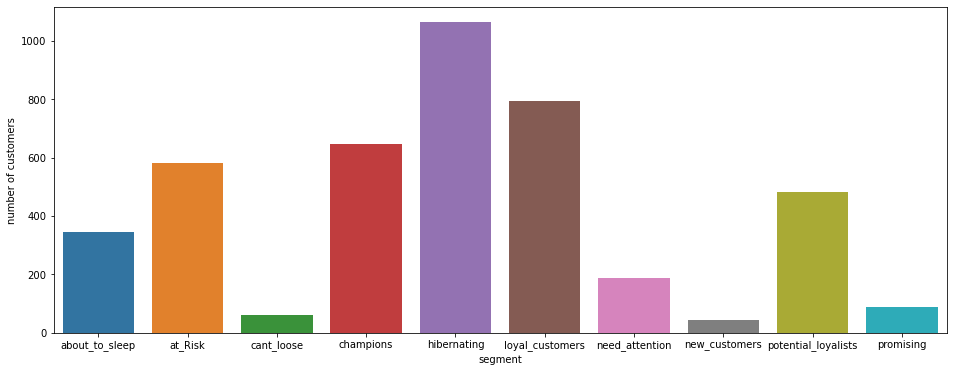

In [18]:
# Visualize number of customers in each segment

group = rfm.groupby('segment')['age']

plt.figure(figsize=(16, 6))
sns.barplot(x=group.count().index, y=group.count());
plt.ylabel('number of customers');

Based on the segmentation, we can focus on the group that are at risk or need attention. We can build tailored marketing activities to build better customer relationship, thus making them to purchase more frequently and potentially turning them into loyal customers. 

Can't Loose and At Risk are customers with frequent purchases this year. However, their recency score was low, we may loose these customers if no action was taken. We should put marking effort to these groups to make them active and loyal again.

Need Attention is another segment that needs to be taken care of. They were customers with regular purchases, they spent good amount of money. If we can put more effort into this group, we can transform them into a loyal customer or even a champion. 

### 3. Customer Life Time Value 

Customer lifetime value is the total amount a customer will bring to the company throughout their entire time as a customer.

#### 3.1 Beta-geometric/negative binomial model for customer alive probability

The model can predict the probability of the user activity during a specific period of time and the expected number of transactions in a certain future period (which is the base to understand the whole value of particular customer during lifetime).

In [19]:
# Removing one-time purchases from dataset
rfm = rfm[(rfm['frequency'] > 1)]

# Creating BG-NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'], rfm['recency_bg'], rfm['age'])

# Prediction of expected number of transaction for each customer for one year (365 days)
rfm['expctd_num_of_purch'] = bgf.predict(365, rfm['frequency'], rfm['recency_bg'], rfm['age']) 

rfm.sort_values("expctd_num_of_purch", ascending=False).head()

,recency,recency_bg,frequency,monetary,age,R,F,M,RFM_Segment,RFM_Score,kmean,RF_Score,segment,expctd_num_of_purch
Customer ID,,,,,,,,,,,,,,
12748.0,3,373,205,29411.98,376,5,5,5,555,15,0,55,champions,157.573955
14911.0,4,372,198,125132.11,376,5,5,5,555,15,0,55,champions,152.074765
17841.0,4,372,124,39360.62,376,5,5,5,555,15,0,55,champions,95.928604
13089.0,5,367,94,55414.66,372,5,5,5,555,15,0,55,champions,73.698384
15311.0,3,373,91,56591.06,376,5,5,5,555,15,0,55,champions,70.886515


As expected, all highest predicted numbers of purchases for one year are cluster 1 customers or champions.

#### 3.2 Gamma-Gamma model for Customer lifetime value

In [20]:
## Convert monetary to monetary_avg

rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

In [21]:
# Creating Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

# Prediction of expected amount of average revenue
rfm["expct_avg_spend"] = ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary_avg'])

rfm.head()

,recency,recency_bg,frequency,monetary_avg,age,R,F,M,RFM_Segment,RFM_Score,kmean,RF_Score,segment,expctd_num_of_purch,expct_avg_spend
Customer ID,,,,,,,,,,,,,,,
12347.0,5,365,7,580.057143,370,5,5,5,555,15,0,55,champions,7.026262,595.165504
12348.0,78,283,4,296.670000,361,2,4,4,244,10,0,24,at_Risk,4.586626,310.929491
12352.0,39,260,7,197.962857,299,3,5,4,354,12,0,35,loyal_customers,8.101104,203.480026
12356.0,25,303,3,829.143333,328,4,3,5,435,12,0,43,potential_loyalists,4.288001,880.711192
12358.0,4,149,2,464.030000,153,5,2,4,524,11,1,52,potential_loyalists,5.878853,509.573665


In [22]:
# Calculating customer lifetime value in one year by using BG-NBD and GammaGamma models: 

rfm["cltv_one_year"] = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_bg'],
                                   rfm['age'],
                                   rfm['monetary_avg'],
                                   time=12,  # 12 month
                                   discount_rate=0.01)

rfm.sort_values("cltv_one_year",ascending=False).head()

,recency,recency_bg,frequency,monetary_avg,age,R,F,M,RFM_Segment,RFM_Score,kmean,RF_Score,segment,expctd_num_of_purch,expct_avg_spend,cltv_one_year
Customer ID,,,,,,,,,,,,,,,,
14646.0,5,352,63,2523.298413,357,5,5,5,555,15,0,55,champions,51.585489,2530.242027,120879.866636
14096.0,7,97,17,2817.365294,104,5,5,5,555,15,1,55,champions,33.978442,2846.284125,89639.184503
14911.0,4,372,198,631.980354,376,5,5,5,555,15,0,55,champions,152.074765,632.546849,89083.558595
12415.0,27,313,15,4466.958000,340,4,5,5,455,14,0,45,loyal_customers,13.907647,4518.845459,58206.135614
17511.0,5,371,30,2435.213000,376,5,5,5,555,15,0,55,champions,24.440323,2449.332302,55438.065918


This model is capable of generating valuable information to be utilized for many purposes in Customer Relationship Management (CRM). The business can make many decisions based on the customer segment and customer life time value information. 

We can extract any at risk and need attention customers with high life time value to Customer Relationship Mangement to increase customer engagement with the company. 